In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect("idoe_corp_data.db")
curs = conn.cursor()
index_commands = [
    'CREATE INDEX IF NOT EXISTS idx_cees_corpid ON corp_enrollment_ell_sped_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ctgr_corpid ON corp_third_grade_reading("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cee_corpid ON corp_enrollment_ethnicity_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ca_corpid ON corp_act("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_car_corpid ON corp_attendance_rates("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cca_corpid ON corp_absenteeism("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ela_corpid ON corp_ilearn_ela("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_math_corpid ON corp_ilearn_math("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cf_corpid ON corp_finances("Corporation ID");',
]

# Execute each index creation
for cmd in index_commands:
    curs.execute(cmd)


In [4]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables["name"]:
    print(table)
    columns = pd.read_sql_query("PRAGMA table_info("+table+");", conn)
    print(columns["name"])

corp_enrollment_grade_gender
0              Corporation ID
1                   Corp Name
2                Pre-K Female
3                  Pre-K Male
4         Kindergarten Female
5           Kindergarten Male
6              Grade 1 Female
7                Grade 1 Male
8              Grade 2 Female
9                Grade 2 Male
10             Grade 3 Female
11               Grade 3 Male
12             Grade 4 Female
13               Grade 4 Male
14             Grade 5 Female
15               Grade 5 Male
16             Grade 6 Female
17               Grade 6 Male
18             Grade 7 Female
19               Grade 7 Male
20             Grade 8 Female
21               Grade 8 Male
22             Grade 9 Female
23               Grade 9 Male
24            Grade 10 Female
25              Grade 10 Male
26            Grade 11 Female
27              Grade 11 Male
28            Grade 12 Female
29              Grade 12 Male
30     Grade 12+/Adult Female
31       Grade 12+/Adult Male
32    TOTAL

In [5]:
f = pd.read_sql_query("SELECT * FROM corp_finances limit 10;", conn)
f.head()

,Year,Corporation ID,Corporation Name,IDOE School ID,School Name,Enrollment,School Per/Student,Corp Per/Student,State Per/Student,Corp Percent Change,State Percent Change,Instructional per/student,OtherInstructional per/student,InstructionalShared per/student,Operational per/student,OperationalShared per/student,FedFund per/student,StateLocalFund per/student,ExcludedOtherExpend per/student,ExcludedFoodExpend per/student
0,2022,0015,Adams Central Community Schools,0013,Adams Central Middle School,313.0,9501.99,9659.39,9917.29,-1.629502,-4.187636,5448.30,0.0,1825.57,0.00,2228.12,1546.24,7955.75,4206.17,400.31
1,2022,0015,Adams Central Community Schools,0020,Adams Central Elementary School,645.0,9158.21,9659.39,9917.29,-5.188526,-7.654107,5104.52,0.0,1825.57,0.00,2228.12,1784.43,7373.79,4206.17,400.31
2,2022,0015,Adams Central Community Schools,0021,Adams Central High School,368.0,10671.67,9659.39,9917.29,10.479751,7.606715,6617.98,0.0,1825.57,0.00,2228.12,1556.39,9115.28,4206.17,400.31
3,2022,0025,North Adams Community Schools,0029,Bellmont Senior High School,641.0,13427.05,12311.39,9917.29,9.062015,35.390313,7175.41,0.0,2690.85,826.17,2734.62,2596.91,10830.14,4334.23,678.99
4,2022,0025,North Adams Community Schools,0033,Bellmont Middle School,326.0,12788.56,12311.39,9917.29,3.875842,28.952163,6669.09,0.0,2690.85,694.00,2734.62,2603.41,10185.14,3884.51,678.99


In [6]:
query = """
SELECT 
    cees."Corporation ID", 
    cees."Corp Name",
    AVG(ctgr."Non-GCE, Promoted to 4th Grade" * 1.0 / ctgr."Number of Test Takers") AS "Non-GCE Promote %",
    cees."ELL %",
    cees."Special Education %",
    CAST(cee."Free/Reduced Price Meals" AS REAL) / cees."Total Enrollment" AS "FRPM_%",
    CAST(cee."Paid Meals" AS REAL) / cees."Total Enrollment" AS "FULL_PRICE_%",
    AVG(cca."Chronically Absent Percent") as "Chronically Absent Percent",
    AVG(car."2023-2024 ATTENDANCE RATE") AS "AVG_ATT_RATE",
    cees."Total Enrollment",
    ela."ELA Proficient %",
    math."Math Proficient %",
    AVG(cf."Corp Per/Student") AS "Corp Per/Student"
FROM corp_enrollment_ell_sped_2024 cees
INNER JOIN corp_third_grade_reading ctgr 
    ON cees."Corporation ID" = ctgr."Corporation ID"
INNER JOIN corp_enrollment_ethnicity_2024 cee 
    ON cees."Corporation ID" = cee."Corporation ID"
INNER JOIN corp_act ca 
    ON cees."Corporation ID" = ca."Corporation ID"
INNER JOIN corp_attendance_rates car 
    ON ca."Corporation ID" = car."Corporation ID"
INNER JOIN corp_absenteeism cca 
    ON car."Corporation ID" = cca."Corporation ID"
INNER JOIN corp_ilearn_ela ela 
    ON cca."Corporation ID" = ela."Corporation ID"
INNER JOIN corp_ilearn_math math 
    ON ela."Corporation ID" = math."Corporation ID"
INNER JOIN corp_finances cf 
    ON cees."Corporation ID" = cf."Corporation ID"
GROUP BY 
    cees."Corporation ID", 
    cees."Corp Name",  
    cees."ELL %", 
    cees."Special Education %", 
    cee."Free/Reduced Price Meals", 
    cee."Paid Meals", 
    cees."Total Enrollment", 
    ela."ELA Proficient %", 
    math."Math Proficient %"
"""
df = pd.read_sql_query(query, conn)
df.head()

,Corporation ID,Corp Name,Non-GCE Promote %,ELL %,Special Education %,FRPM_%,FULL_PRICE_%,Chronically Absent Percent,AVG_ATT_RATE,Total Enrollment,ELA Proficient %,Math Proficient %,Corp Per/Student
0,15,Adams Central Community Schools,0.017691,0.023529,0.152941,0.271324,0.728676,0.038941,0.966399,1360,0.484034,0.611765,9659.39
1,25,North Adams Community Schools,0.042012,0.007600,0.179861,0.454718,0.545282,0.092294,0.973404,1579,0.385740,0.339450,12311.39
2,35,South Adams Schools,0.004467,0.100153,0.188838,0.455657,0.544343,0.074315,0.957031,1308,0.400356,0.521352,12086.48
3,125,MSD Southwest Allen County Schls,0.024144,0.020649,0.119391,0.236400,0.763468,0.031000,0.994553,7555,0.529885,0.528888,8967.90
4,225,Northwest Allen County Schools,0.012208,0.036025,0.157700,0.237743,0.762257,0.044749,0.961639,8383,0.489105,0.463828,8800.10


   Non-GCE Promote %     ELL %  Special Education %    FRPM_%  FULL_PRICE_%  \
0           0.017691  0.023529             0.152941  0.271324      0.728676   
1           0.042012  0.007600             0.179861  0.454718      0.545282   
2           0.004467  0.100153             0.188838  0.455657      0.544343   
3           0.024144  0.020649             0.119391  0.236400      0.763468   
4           0.012208  0.036025             0.157700  0.237743      0.762257   

   Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
0                    0.038941      0.966399              1360   
1                    0.092294      0.973404              1579   
2                    0.074315      0.957031              1308   
3                    0.031000      0.994553              7555   
4                    0.044749      0.961639              8383   

   Corp Per/Student  ELA Proficient %  Math Proficient %  
0           9659.39          0.484034           0.611765  
1          12311

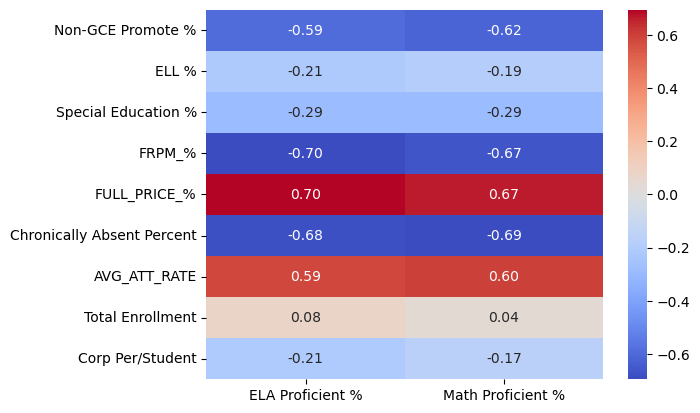

In [8]:
X = ["Non-GCE Promote %", "ELL %", "Special Education %", "FRPM_%", "FULL_PRICE_%", "Chronically Absent Percent", "AVG_ATT_RATE", "Total Enrollment", "Corp Per/Student"]
Y = ["ELA Proficient %", "Math Proficient %"]
subset = df[X + Y]
print(subset.head())
corrs = subset.corr().loc[X, Y]
feature_label_corr_map = plt.figure()
sns.heatmap(corrs, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.show()

In [17]:
feature_label_corr_map.savefig("feature_label_correlation_heatmap.png", dpi=300, bbox_inches='tight')

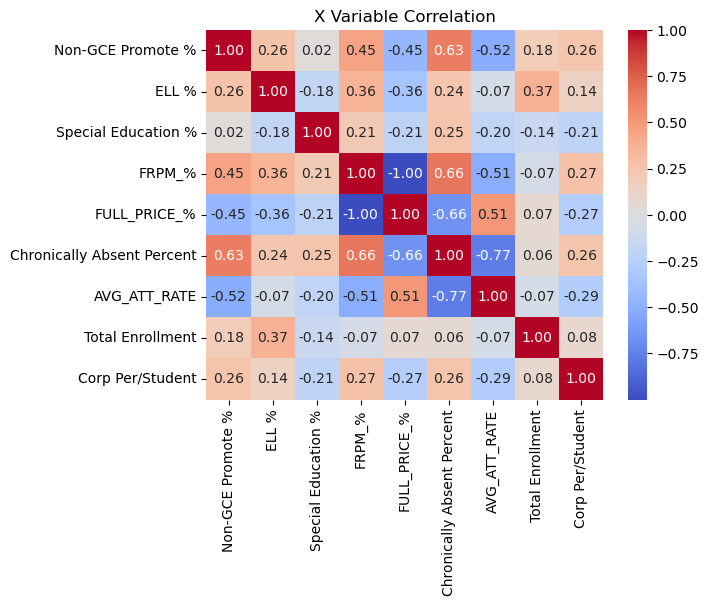

In [9]:
x_corr = df[X].corr()
feature_feature_corr_map = plt.figure()
sns.heatmap(x_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("X Variable Correlation")
plt.show()

In [19]:
feature_feature_corr_map.savefig("feature_feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')

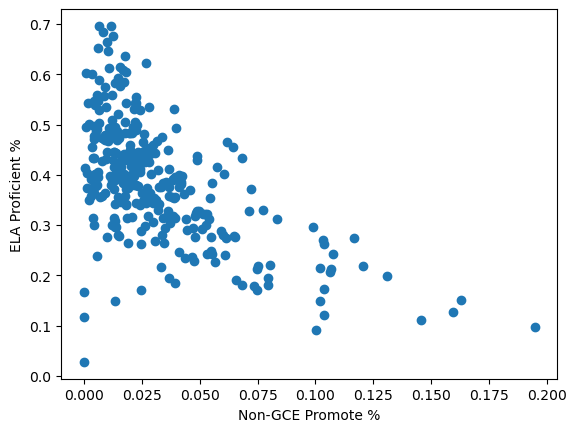

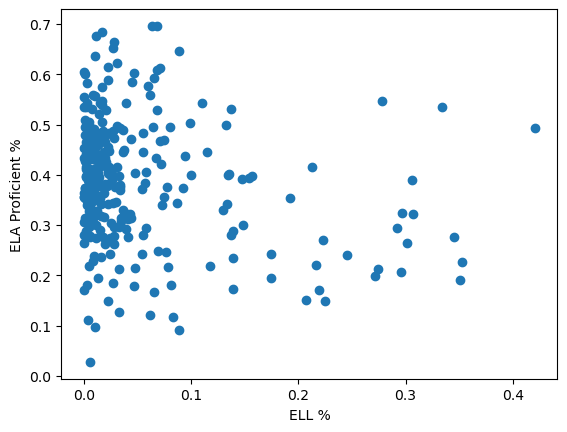

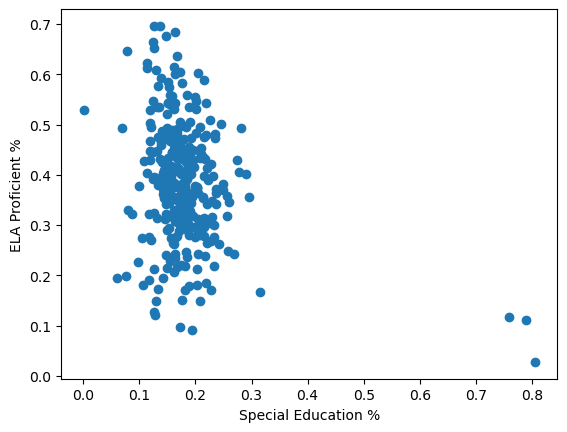

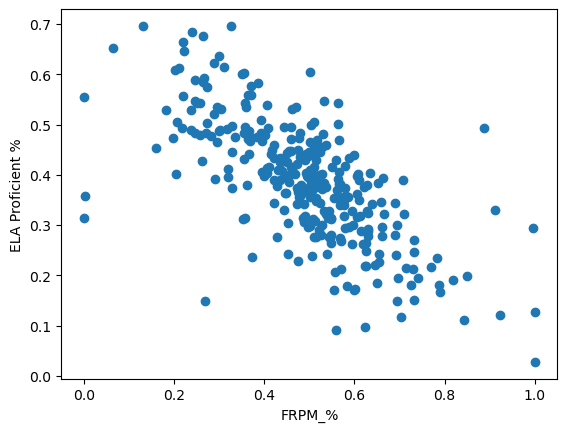

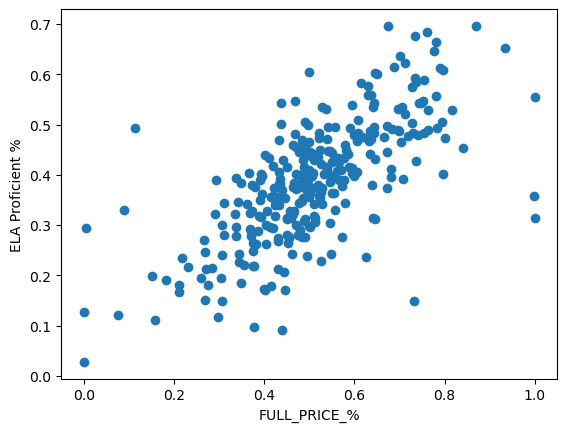

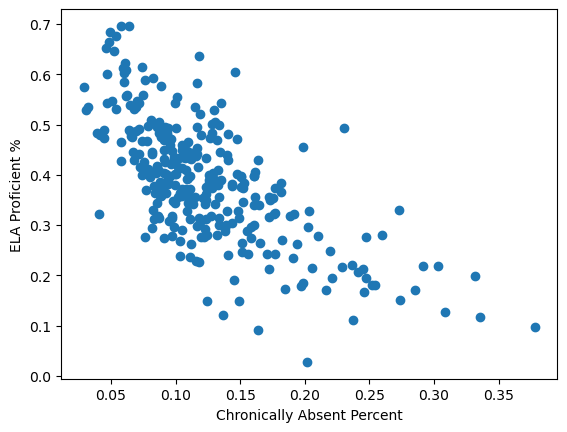

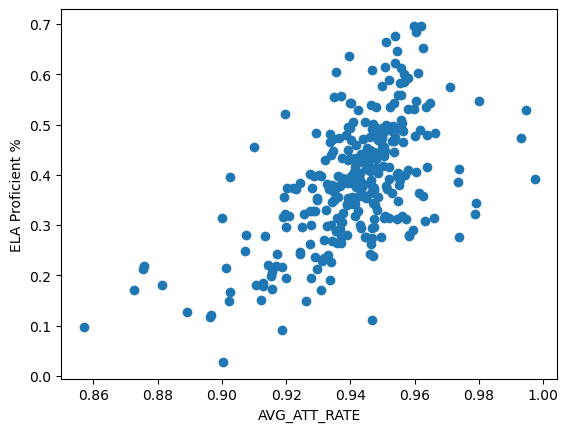

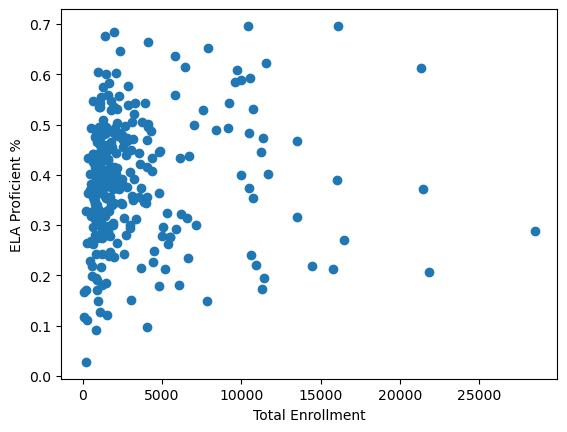

FileNotFoundError: [Errno 2] No such file or directory: 'scatter_Corp_Per/Student.png'

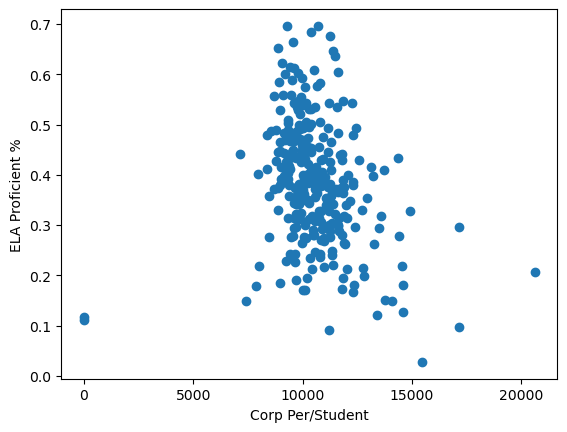

In [10]:
for col in X:
    plt.figure()
    plt.scatter(df[col], df["ELA Proficient %"])
    plt.xlabel(col)
    plt.ylabel("ELA Proficient %")
    
    filename = f"scatter_{col.replace('%', '').replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

C:\Users\lehma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\lehma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\lehma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\lehma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

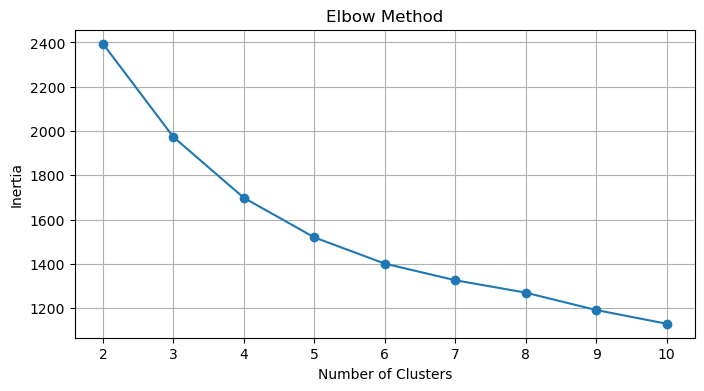

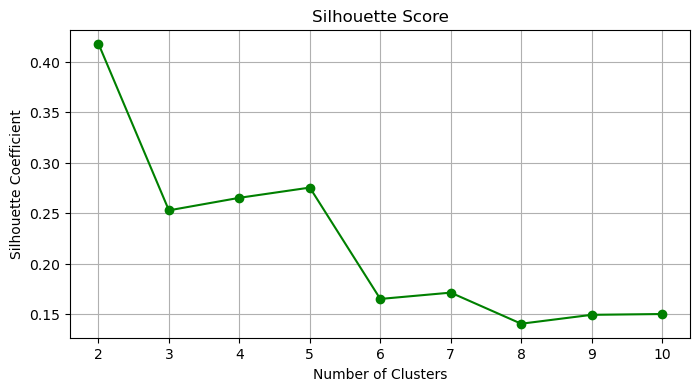

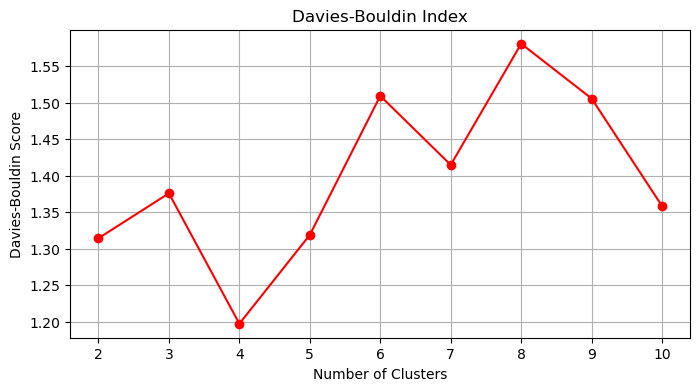

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Prepare and standardize the data
features = subset.values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Initialize empty lists to store evaluation metrics
inertia = []
silhouette_scores = []
davies_scores = []

k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_features)
    
    inertia.append(kmeans.inertia_)  # for Elbow
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    davies_scores.append(davies_bouldin_score(scaled_features, labels))

# Plot Elbow Method (Inertia)
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plot Silhouette Coefficient
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 4))
plt.plot(k_values, davies_scores, marker='o', color='red')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

corp_ids = df["Corporation ID"]
corp_names = df["Corp Name"]

X = df.drop(columns=["Corporation ID", "Corp Name"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_profiles = df.groupby("Cluster").mean(numeric_only=True)
print(cluster_profiles.T)

Cluster                                0            1             2  \
Corporation ID               6336.718750  4403.670886   4904.311377   
Non-GCE Promote %               0.084115     0.014226      0.026452   
ELL %                           0.057918     0.035036      0.025908   
Special Education %             0.172535     0.158414      0.183724   
FRPM_%                          0.675354     0.296676      0.513301   
FULL_PRICE_%                    0.324621     0.703306      0.486670   
Chronically Absent Percent      0.228319     0.077004      0.116805   
AVG_ATT_RATE                    0.908346     0.953305      0.943273   
Total Enrollment             3109.843750  4229.430380   1947.467066   
ELA Proficient %                0.214813     0.518557      0.378964   
Math Proficient %               0.182120     0.548911      0.384308   
Corp Per/Student            11734.522188  9912.015190  10529.025569   

Cluster                               3             4  
Corporation ID      

C:\Users\lehma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


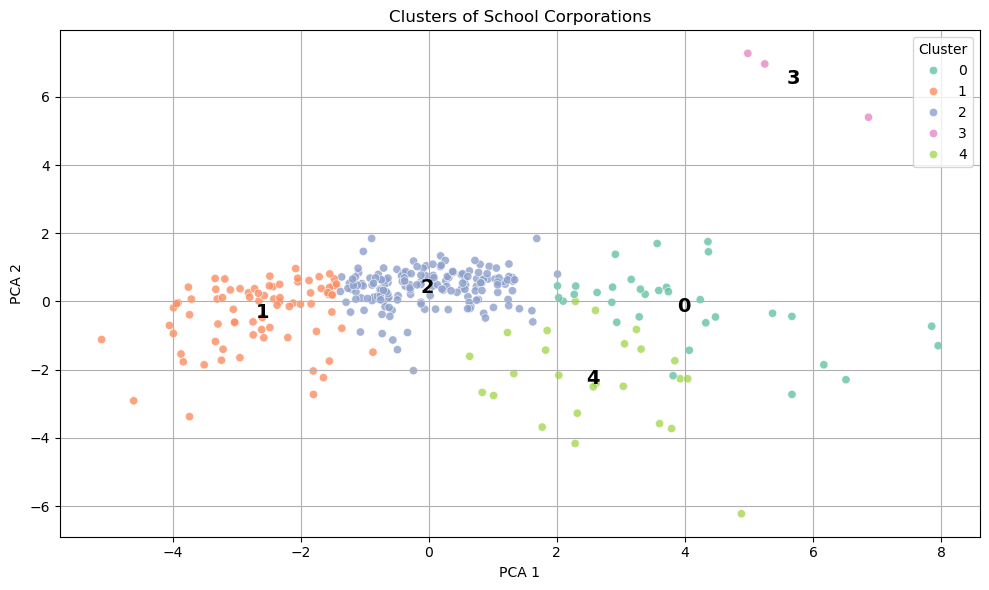

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

prelim_clusters = plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="Set2", alpha=0.8)

cluster_centers = df.groupby("Cluster")[["PCA1", "PCA2"]].mean()
for cluster, (x, y) in cluster_centers.iterrows():
    plt.text(x, y, str(cluster), fontsize=14, fontweight='bold', ha='center', va='center', color='black')

plt.title("Clusters of School Corporations")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
prelim_clusters.savefig("preliminary_clusters.png", dpi=300, bbox_inches='tight')

In [14]:
from sklearn.metrics import pairwise_distances_argmin_min

centers_scaled = kmeans.cluster_centers_
closest_indices, _ = pairwise_distances_argmin_min(centers_scaled, X_scaled)
closest_rows = df.iloc[closest_indices]
closest_rows[["Corporation ID", "Corp Name", "Cluster"] + list(X.columns)]

,Corporation ID,Corp Name,Cluster,Non-GCE Promote %,ELL %,Special Education %,FRPM_%,FULL_PRICE_%,Chronically Absent Percent,AVG_ATT_RATE,Total Enrollment,ELA Proficient %,Math Proficient %,Corp Per/Student
71,2865,Marion Community Schools,0,0.101996,0.047386,0.148693,0.715142,0.284858,0.205710,0.901143,3672,0.214535,0.198740,12750.65
83,3115,New Palestine Community Schools,1,0.018230,0.014593,0.151818,0.251664,0.748336,0.071830,0.953555,3906,0.543711,0.577878,9592.13
159,5265,Alexandria Community School Corp,2,0.032619,0.029181,0.202135,0.535943,0.464057,0.125568,0.941836,1405,0.375000,0.358108,9754.46
295,9605,IN Sch for the Blind & Vis Imprd,3,0.000000,0.083333,0.759259,0.703704,0.296296,0.335252,0.896366,108,0.117647,0.000000,0.00
166,5350,MSD Pike Township,4,0.060934,0.245267,0.148159,0.693039,0.306866,0.140617,0.932925,10617,0.240833,0.177300,11333.87


In [15]:
cluster_3_schools = df[df["Cluster"] == 3]
print(cluster_3_schools)

     Corporation ID                         Corp Name  Non-GCE Promote %  \
295            9605  IN Sch for the Blind & Vis Imprd           0.000000   
296            9610       Indiana School For The Deaf           0.145663   
304            9920             Damar Charter Academy           0.000000   

        ELL %  Special Education %    FRPM_%  FULL_PRICE_%  \
295  0.083333             0.759259  0.703704      0.296296   
296  0.003650             0.788321  0.843066      0.156934   
304  0.005587             0.804469  1.000000      0.000000   

     Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
295                    0.335252      0.896366               108   
296                    0.237127      0.946659               274   
304                    0.201882      0.900479               179   

     ELA Proficient %  Math Proficient %  Corp Per/Student  Cluster      PCA1  \
295          0.117647           0.000000              0.00        3  4.982643   
296          0.